In [1]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np

# II
# Download reference table
w_land = pd.read_csv('../data/w_land.csv')

#  wlands Backup
w_land = w_land.copy()

# III Convert the df into geopandas df
w_land['geometry'] = w_land['geometry'].apply(wkt.loads)
w_land = gpd.GeoDataFrame(w_land, geometry='geometry')


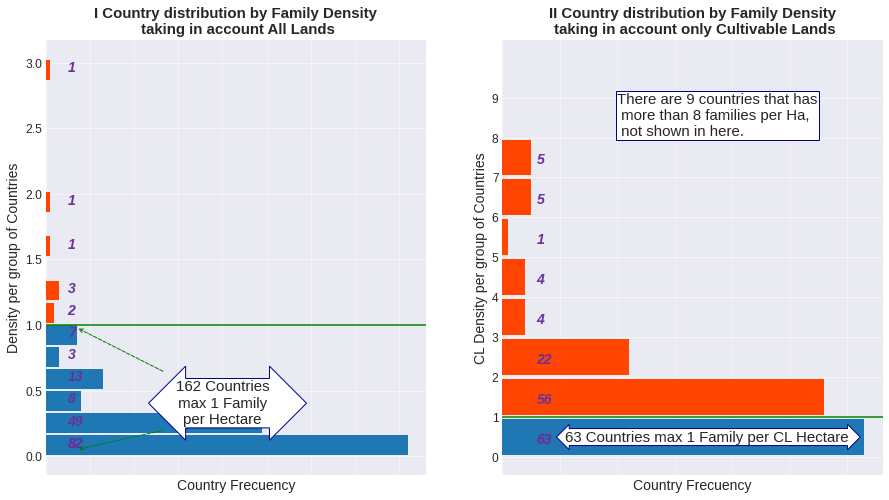

In [3]:
# VI Histogram division

%matplotlib inline

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'xtick.labelsize':12,
                     'ytick.labelsize':12,
                     'ytick.labelleft':'on',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False, 
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     'xtick.top': False,
                     'axes.labelsize':14,
                     'axes.edgecolor':'slategrey',
                     'grid.linewidth':0.5
                    })


fig = plt.figure(figsize=(15,8))

#### GRAPH 1 ####
ax3 = fig.add_subplot(1,2,1)

ax3.set_ylabel('Density per group of Countries')
ax3.set_xlabel('Country Frecuency')
ax3.set_title('I Country distribution by Family Density\n taking in account All Lands', weight='bold', size=15)

a_bins = 18 #15
ax3, bins3, patches3 = plt.hist(w_land['density'],
                               bins= a_bins, orientation='horizontal', rwidth=0.9)

# Putting orange color to the bars >1Ha
for n in range(len(patches3)):
    if patches3[n].xy[1] >1:
        patches3[n].set_fc('orangered')

suma = 0
for n in range(len(patches3)):
    if patches3[n].xy[1] <=1:
        suma +=ax3[n] 
        
        
        
# # Adding the value of each bar (plot1)
high = 0.2
def texto(x,y):
    texto = lambda t: plt.text(x, high + t.xy[1]-y, int(t.get_width()),size=14, 
                           fontweight='bold', fontstyle='oblique', color='rebeccapurple')
    return texto

vfunc1 = np.vectorize(texto(5,0.14))

## Filter the 0 width columns (plot1)
p1 = [patches3[i] for i in range(len(patches3)) if patches3[i].get_width() > 0]
vfunc1(p1)

plt.text(40, 0.25, #+patches3[1].xy[1],
         str(int(suma))+' Countries\n max 1 Family \nper Hectare', 
         fontsize=15 , 
         ha='center',
         bbox=dict(boxstyle='darrow,pad=0.1', fc='white', ec='darkblue'))

# Additional styling
plt.axhline(y=1, color='green') # Adding the reference line
plt.annotate("", xy=(27, 0.20), xytext=(7, 0.05),  arrowprops=dict(arrowstyle="<-", lw= 1, linestyle='--', color='green'))
plt.annotate("", xy=(27, 0.64), xytext=(7, 0.98),  arrowprops=dict(arrowstyle="<-", lw= 1, linestyle='--', color='green'))


#### GRAPH 2 ####
ax4 = fig.add_subplot(1,2,2)

ax4.set_ylabel('CL Density per group of Countries')
ax4.set_xlabel('Country Frecuency')
ax4.set_title('II Country distribution by Family Density\n taking in account only Cultivable Lands', weight='bold', size=15)

b_bins = 10
ax4, bins4, patches4 = plt.hist(w_land['density_CL'],  orientation='horizontal', bins= b_bins,
                            range= [0,10], rwidth=0.9, bottom=0) 

# Text BBoxes with notes
plt.text(11, 0.35+patches4[0].xy[1],str(int(ax4[0]))+' Countries max 1 Family per CL Hectare', fontsize=15 ,
         bbox=dict(boxstyle='darrow,pad=0.1', fc='white', ec='darkblue'))
plt.text(20, 1+patches4[7].xy[1], 
         'There are 9 countries that has\n more than 8 families per Ha,\n not shown in here.', fontsize=15 ,
         bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='darkblue'))

# # Adding the value of each bar (plot2)
high = 0.3
p2 = [patches4[i] for i in range(len(patches4)) if patches4[i].get_width() > 0]

vfunc2 = np.vectorize(texto(6,0))
vfunc2(p2)

# # Aditional styling
plt.axhline(y=1, color='green') # Adding the reference line
plt.yticks(np.arange(0, 10, 1)) # Changing the y steps
#patches4[0].set_fc('orangered')

for n in range(len(patches4)):
    if patches4[n].xy[1] >1:
        patches4[n].set_fc('orangered')


plt.savefig('../images/hist_dens.png')

plt.show()
